## Train MLP Models for CDSO (Index Option) Pricing 

In [30]:
# Library requirements 
import pandas as pd
import numpy as np
import tensorflow as tf
import time 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error , mean_absolute_error, r2_score

%run mlp_models.ipynb
%run plotting.ipynb


## Config Settings  

Configuration settings for Model, Data and Control;   

-   **Model**:   Controlling which model to train with (or load a saved model)  
-   **Data**:    Specify the training features to use and the target label  
-   **Control**: Specify how to normalise the data, how many training epochs, if subsampling and what metric to use. 


In [4]:
# SAVED MODELS
# model_ss_(32_16_8_1_BN_KI_E200_1e5)_(r_c_s_smc_k_logm_iv_tm_te)_logy_(option_contracts_all)
# model_ms_(64_32_16_1_BN_KI_E200_1e5)_(r_c_s_smc_k_logm_iv_tm_te)_logy_(option_contracts_all)
# model_ls_(128_64_32_16_1_BN_KI_E200_1e5)_(r_c_s_smc_k_logm_iv_tm_te)_logy_(option_contracts_all)

# model_sl_(32_16_8_1_BN_KI_E200_1e5)_(r_c_s_smc_k_logm_iv_tm_te)_logy_(option_contracts_dense_all)
# model_ml_(64_32_16_1_BN_KI_E200_1e5)_(r_c_s_smc_k_logm_iv_tm_te)_logy_(option_contracts_dense_all)
# model_ll_(128_64_32_16_1_BN_KI_E200_1e5)_(r_c_s_smc_k_logm_iv_tm_te)_logy_(option_contracts_dense_all)

# model_flat_(20_20_20_20_1_KIG_E200_1e5_SP)_(r_c_s_smc_k_logm_iv_tm_te)_logy_(option_contracts_all)  : BEST MODEL 

config = dict(# Model
              model = 'model_flat',        # model version 
              train_or_load = 'load',      # (train, load) 
              model_path ='./saved_models/', 
              model_save_name = '',        # train_or_load == 'train'
              model_load_name = 'model_flat_(20_20_20_20_1_KIG_E200_1e5_SP)_(r_c_s_smc_k_logm_iv_tm_te)_logy_(option_contracts_all)',        # train_or_load == 'load'

              # Data 
              data_path = "./../../data/", 
              data_name = "option_priced.csv",    # (index_priced.csv, index_priced_dense.csv)
              X = ('optionType','recovery', 'coupon', 'spread', 'smc', 'strike', 'logM', 'impliedVol', 'exp_duration', 'mat_duration'),  # features to train on 
              y = ('mtm',),

              # Control Parameters 
              transform_y = 'scale_and_log',     # (scale_only, scale_and_log)
              epochs = 200,
              apply_sampling = True,
              apply_rounding = True,
              loss = 'mean_absolute_error'       # (mean_absolute_error, mean_squared_error)
)


## Load and Sample Data  

Load the training data and filter for only what we need for model training. 

In [5]:
# Read the CDS Index contracts 
data = pd.read_csv(config['data_path'] + config['data_name'])
data = data[list(config['X'] + config['y'])]

if config['apply_sampling']:
    # add any subsampling required here ...  
    sampled_data = data[data.mtm.abs() > 1e-5].copy()
else:
    sampled_data = data.copy() 

if (config['apply_rounding']):    
    sampled_data[['mtm', 'spread', 'strike', 'smc', 'logM', 'impliedVol']] = sampled_data[['mtm', 'spread', 'strike', 'smc', 'logM', 'impliedVol']].round(8)


sampled_data


,optionType,recovery,coupon,spread,smc,strike,logM,impliedVol,exp_duration,mat_duration,mtm
2,1,0.4,100,0.005034,-0.004966,0.005414,0.072853,0.102364,0.133333,4.625000,0.000060
3,1,0.4,100,0.005034,-0.004966,0.005414,0.072853,0.102364,0.133333,5.130556,0.000056
4,1,0.4,100,0.005034,-0.004966,0.005414,0.072853,0.102364,0.230556,4.625000,0.000275
5,1,0.4,100,0.005034,-0.004966,0.005414,0.072853,0.102364,0.230556,5.130556,0.000260
6,1,0.4,100,0.005034,-0.004966,0.005414,0.072853,0.303473,0.055556,4.625000,0.000184
...,...,...,...,...,...,...,...,...,...,...,...
353385,-1,0.4,500,0.060084,0.010084,0.054628,-0.095204,1.701940,0.016667,4.916667,0.009452
353386,-1,0.3,500,0.060084,0.010084,0.054628,-0.095204,1.902750,0.016667,4.411111,0.010823
353387,-1,0.4,500,0.060084,0.010084,0.054628,-0.095204,1.902750,0.016667,4.411111,0.010472
353388,-1,0.3,500,0.060084,0.010084,0.054628,-0.095204,1.902750,0.016667,4.916667,0.011749


## Batch and Transform Data  

Normalise the data features, create a train:test split and batch the data.  

In [6]:
# Scale X always 
X = sampled_data.drop(columns=['mtm'])
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Scale y ?
y_scaled = sampled_data['mtm'].values.reshape(-1, 1)
if config['transform_y'] == 'scale_and_log':
    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y_scaled)
    y_scaled = np.log1p(y_scaled)
    
elif config['transform_y'] == 'scale_only':
    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
# Batch the data 
batch_size = 32
# Convert the data to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
# Shuffle and batch the datasets
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Print out the shapes to verify
for X_batch, y_batch in train_dataset.take(1):
    print(f'X_batch shape: {X_batch.shape}')
    print(f'y_batch shape: {y_batch.shape}')


X_batch shape: (32, 10)
y_batch shape: (32, 1)


## Build, Compile and Fit the Model (or load saved model) 

In [28]:

if config['train_or_load'] == 'train':
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    model = build_model(config['model'], X_train)    
    model.compile(optimizer=Adam(learning_rate=0.001), loss=config['loss'])
    start_time = time.time()
    history = model.fit(train_dataset, epochs=config['epochs'], validation_data=test_dataset, callbacks=[early_stopping])
    end_time = time.time()
    total_time = end_time - start_time
    model.save(config['model_path'] + config['model_save_name'])
    plot_training_loss(history)
    print(f"Total training time: {total_time:.2f} seconds")

elif config['train_or_load'] == 'load':
    model = load_model(config['model_path'] + config['model_load_name'])

else:
    raise ValueError(f"Unrecognized value for 'train_or_load': {config['train_or_load']}. Expected 'train' or 'load'.")

model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FWD_L1 (Dense)              (None, 20)                220       
                                                                 
 FWD_L2 (Dense)              (None, 20)                420       
                                                                 
 FWD_L3 (Dense)              (None, 20)                420       
                                                                 
 FWD_L4 (Dense)              (None, 20)                420       
                                                                 
 y_pred (Dense)              (None, 1)                 21        
                                                                 
Total params: 1501 (5.86 KB)
Trainable params: 1501 (5.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Evaluate the Model  

Evaluate the model on the test set and create a dataframe useful for analysing the distribution and size of relative and absolute accuracy of ground truth vs predicted MtMs.  

2108/2108 [==============================] - 2s 825us/step
Mean Absolute Error on test set: 0.0001137479590028037


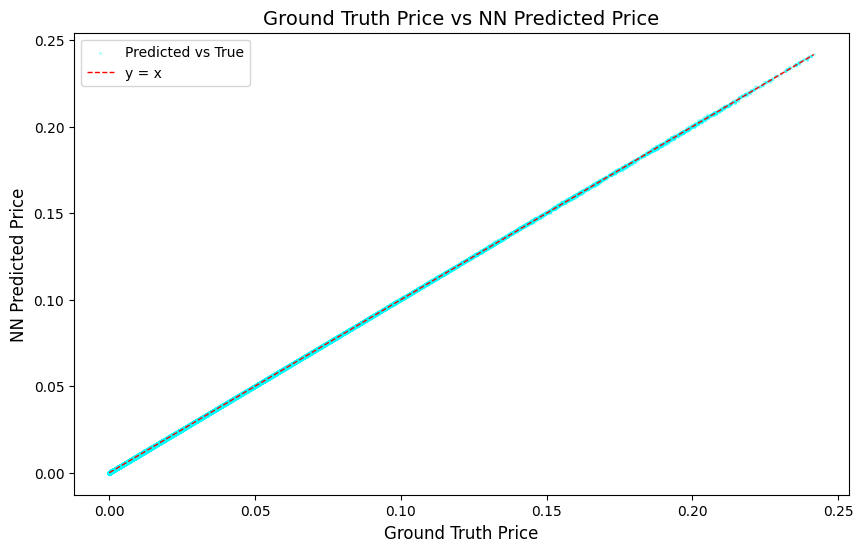

In [32]:

# Evaluate the model
y_pred = model.predict(X_test)

# Reverse any y transformations 
if config['transform_y'] == 'scale_and_log':
    y_pred = np.expm1(y_pred)  # Reverse the log1p transformation
    y_pred = scaler_y.inverse_transform(y_pred)
    y_test_ = np.expm1(y_test)
    y_test_ = scaler_y.inverse_transform(y_test_)

elif config['transform_y'] == 'scale_only':
    y_pred = scaler_y.inverse_transform(y_pred)
    y_test_ = scaler_y.inverse_transform(y_test)

if config['loss'] == 'mean_squared_error':
    mse = mean_squared_error(y_test_, y_pred)
    print(f'Mean Squared Error on test set: {mse}')
elif config['loss'] == 'mean_absolute_error':
    mse = mean_absolute_error(y_test_, y_pred)
    print(f'Mean Absolute Error on test set: {mse}')

# Plot ground truth vs NN predictions on test set 
plot_pred_vs_test(y_test_, y_pred, 'Ground Truth Price vs NN Predicted Price', 'Ground Truth Price', 'NN Predicted Price')

# Create a data frame with y_test and y_pred values and the relative and absolute diffs 
df = pd.DataFrame({
    'y_test': y_test_.flatten(),
    'y_pred': y_pred.flatten()
})
df['diff_rel'] = (df['y_test'] - df['y_pred']) / df['y_test'] * 100
df['diff_abs'] = (df['y_test'] - df['y_pred']) 


## Prediction Errors  
Amanlyse the prediction relative and absolute prediction accuracy across MtM bins and uniformly across the entire test set.  

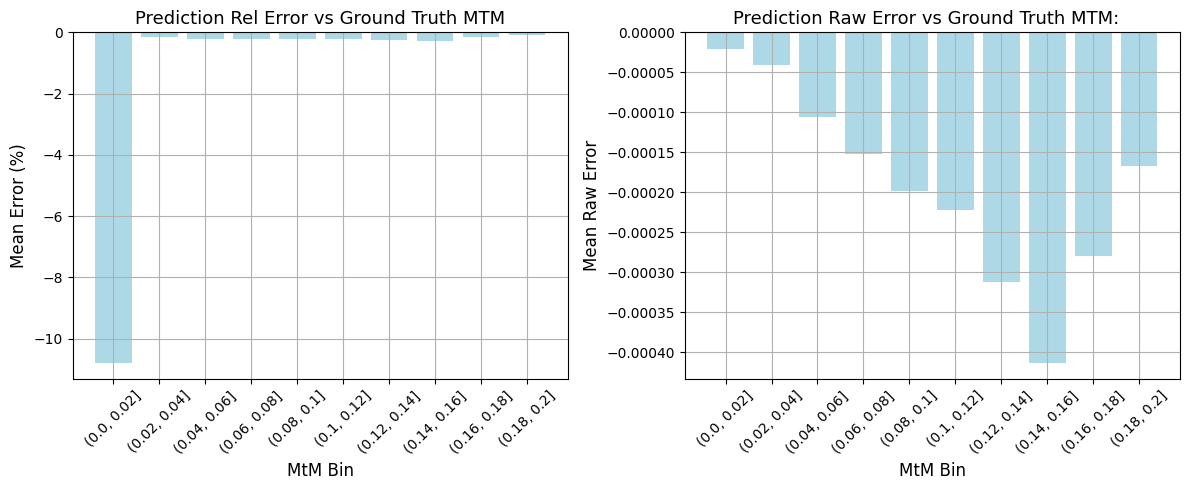

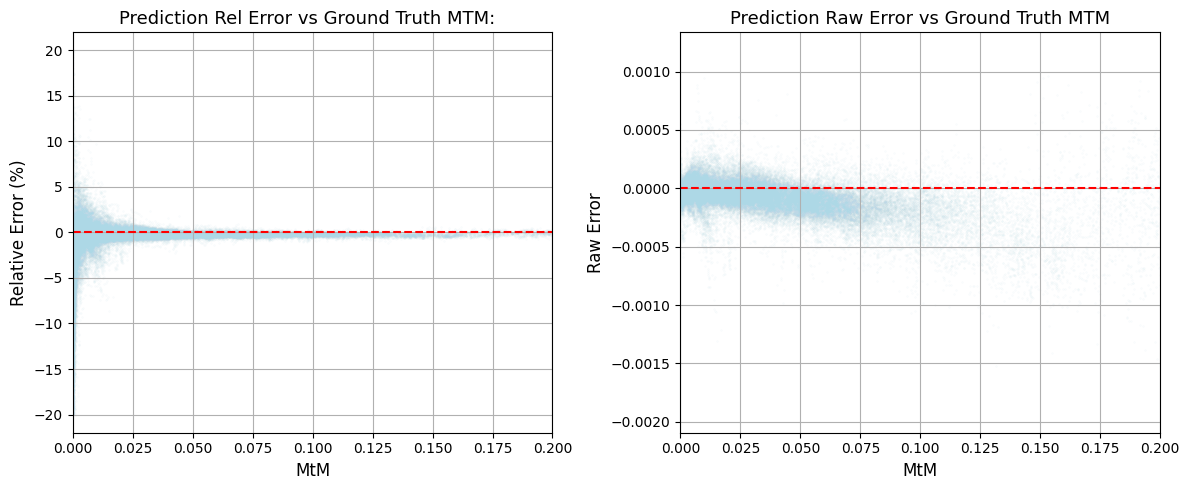

,mtm_bin,diff_rel
0,"(0.0, 0.02]",-10.781542
1,"(0.02, 0.04]",-0.136514
2,"(0.04, 0.06]",-0.210557
3,"(0.06, 0.08]",-0.220867
4,"(0.08, 0.1]",-0.221721
5,"(0.1, 0.12]",-0.203698
6,"(0.12, 0.14]",-0.240263
7,"(0.14, 0.16]",-0.276817
8,"(0.16, 0.18]",-0.166754
9,"(0.18, 0.2]",-0.087632


In [31]:
# Mean percentage prediction error across MtM bins 
df_trunc = df[df.y_test.abs() > 1e-5]
bin_errors = plot_pred_error_rel_twice(df, df_trunc, 'opt', 'Prediction Rel Error vs Ground Truth Price', 'Prediction Raw Error vs Ground Truth Price:  ')

# Relative and absolute prediction errors (no bins) 
df_rel = df[df['diff_rel'].abs() < 20 ]
plot_pred_error_twice(df_rel, df, 'opt', 'Prediction Rel Error vs Ground Truth Price:  ', 'Prediction Raw Error vs Ground Truth Price')
bin_errors[0]

## Calculate Metrics

In [231]:
# Calculate some metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 0.017443428849385073
Root Mean Squared Error (RMSE): 0.13207357362237562
Mean Absolute Error (MAE): 0.09463123435530031


## NN Model Inference Performance against BBG CDSO Standard Pricer

In [232]:
# Time the inference of the entire training set and compare to the time taken by the Standard ISDA Pricer 
opt_small_bbg_time = 214
opt_large_bbg_time = 2000

start_time = time.time()
y_pred_all = model.predict(X_train)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"All Training Data Inference Time: {elapsed_time:.1f} seconds")
print(f"BBG Standard Pricer Time: {opt_large_bbg_time:.1f} seconds")  # From Julia code execution time
print(f"Speedup = {(X_train.shape[0] / sampled_data.shape[0] * opt_large_bbg_time)/ elapsed_time:.1f} x")


8432/8432 [==============================] - 7s 812us/step
All Training Data Inference Time: 10.0 seconds
BBG Standard Pricer Time: 2000.0 seconds
Speedup = 159.5 x


## Model Comparison Table 

In [27]:
# model_ss_(32_16_8_1_BN_KI_E200_1e5)_(r_c_s_smc_t)_logy_(option_contracts_all)
# model_ms_(64_32_16_1_BN_KI_E200_1e5)_(r_c_s_smc_t)_logy_(option_contracts_all)
# model_ls_(128_64_32_16_1_BN_KI_E200_1e5)_(r_c_s_smc_t)_logy_(option_contracts_all)

data_small_sample = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'Train Time', 'Model Size', 'X_train Size', 'Inference Time', 'BBG Time', 'Speed Up x'],
    'Model Small': [0.094, 0.017, 0.132, 644, 205, 269794, 11.0, 171.2, 171.2/11],
    'Model Medium': [0.094, 0.018, 0.132, 446, 205, 269794, 9.6, 171.2, 171.2/9.6],
    'Model Large': [0.095, 0.017, 0.132, 367, 274, 269794, 10.0, 171.2, 171.2/10]
}

df_small = pd.DataFrame(data_small_sample)
df_small = df_small.round({'Model Small': 3, 'Model Medium': 3, 'Model Large':3})
df_small

# model_sl_(32_16_8_1_BN_KI_E200_1e5)_(r_c_s_smc_t)_logy_(option_contracts_dense_all)
# model_ml_(64_32_16_1_BN_KI_E200_1e5)_(r_c_s_smc_t)_logy_(option_contracts_dense_all)
# model_ll_(128_64_32_16_1_BN_KI_E200_1e5)_(r_c_s_smc_t)_logy_(option_contracts_dense_all)

data_large_sample = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'Train Time', 'Model # Parameters', 'X_train Size', 'T4 GPU Inference Time', 'BBG Pricer Time', 'Speed Up x'],
    'Model Small (32:16:8:1)': [0.082, 0.013, 0.114, 6850, 1057, 2683532, 7.5, 1599, 1599/7.5],
    'Model Medium (64:32:16:1)': [0.082, 0.013, 0.114, 6914, 3393, 2683532, 7.2, 1599, 1599/7.2],
    'Model Large (128:64:32:16:1)': [0.082, 0.013, 0.115, 9003, 12545, 2683532, 7.2, 1599, 1599/7.2],
    'Model Flat (20:20:20:20:1)': [0.081, 0.13, 0.114, 6875, 1401, 2683532, 6.8, 1599, 1599/6.8]
}

df_large = pd.DataFrame(data_large_sample)
df_large = df_large.round({'Model Small (32:16:8:1)': 3, 'Model Medium (64:32:16:1)': 3, 'Model Large (128:64:32:16:1)':3, 'Model Flat (20:20:20:20:1)':3})
df_large


,Metric,Model Small (32:16:8:1),Model Medium (64:32:16:1),Model Large (128:64:32:16:1),Model Flat (20:20:20:20:1)
0,MAE,0.082,0.082,0.082,0.081
1,MSE,0.013,0.013,0.013,0.130
2,RMSE,0.114,0.114,0.115,0.114
3,Train Time,6850.000,6914.000,9003.000,6875.000
4,Model # Parameters,1057.000,3393.000,12545.000,1401.000
5,X_train Size,2683532.000,2683532.000,2683532.000,2683532.000
6,T4 GPU Inference Time,7.500,7.200,7.200,6.800
7,BBG Pricer Time,1599.000,1599.000,1599.000,1599.000
8,Speed Up x,213.200,222.083,222.083,235.147


In [ ]:
6875